In [ ]:
#@title Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
from google.colab import drive

from sklearn.utils import resample
from scipy import stats

from sklearn.metrics import confusion_matrix, classification_report
 
%matplotlib inline
tf.random.set_seed(42)

In [ ]:
#@title Data download
drive.mount('/content/drive/')

!cp "/content/drive/MyDrive/boiled_data.csv" "/home/"
df = pd.read_csv('/home/boiled_data.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#@title Downsampling
df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]
 
df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

11    30720
10    30720
9     30720
5     30720
4     30720
3     30720
2     30720
1     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [ ]:
df1 = df.copy()

for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)

In [ ]:
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

In [ ]:
train = df1[(df1['subject'] != 'subject9') & (df1['subject'] != 'subject10')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape

((266295, 8), (69386, 8))

In [ ]:
X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'],axis=1)
y_test = test['Activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((266295, 6), (266295,), (69386, 6), (69386,))

In [ ]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
X_train,y_train = create_dataset(X_train, y_train, 100, step=50)
X_train.shape, y_train.shape

((5324, 100, 6), (5324, 1))

In [ ]:
X_test,y_test = create_dataset(X_test, y_test, 100, step=50)
X_test.shape, y_test.shape

((1386, 100, 6), (1386, 1))

In [ ]:
model = keras.Sequential()
model.add(layers.InputLayer(input_shape=[100,6]))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.GRU(64))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(len(label_map), activation='softmax'))

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/gruModel.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]
 
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)
 
model_history = model.fit(X_train,y_train, epochs= 1000, validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/1000
167/167 [==============================] - 4s 12ms/step - loss: 1.7348 - sparse_categorical_accuracy: 0.4375 - val_loss: 1.4073 - val_sparse_categorical_accuracy: 0.6068
Epoch 2/1000
167/167 [==============================] - 1s 7ms/step - loss: 0.5348 - sparse_categorical_accuracy: 0.8033 - val_loss: 0.4400 - val_sparse_categorical_accuracy: 0.8160
Epoch 3/1000
167/167 [==============================] - 1s 7ms/step - loss: 0.3020 - sparse_categorical_accuracy: 0.8999 - val_loss: 0.4260 - val_sparse_categorical_accuracy: 0.8110
Epoch 4/1000
167/167 [==============================] - 1s 7ms/step - loss: 0.2071 - sparse_categorical_accuracy: 0.9268 - val_loss: 0.3931 - val_sparse_categorical_accuracy: 0.8773
Epoch 5/1000
167/167 [==============================] - 1s 7ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.9402 - val_loss: 0.3093 - val_sparse_categorical_accuracy: 0.8579
Epoch 6/1000
167/167 [==============================] - 1s 7ms/step - loss: 0.1124 - spar

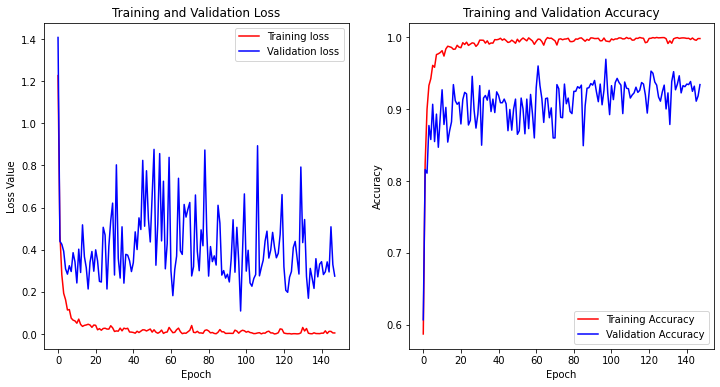

In [ ]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/gruModel.h5')

train_loss, train_acc = model.evaluate(X_train,y_train)
test_loss, test_acc = model.evaluate(X_test,y_test)

print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

44/44 [==============================] - 0s 4ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.9697
Train accuracy 99.96 %
Train loss 0.0020074239000678062
Test accuracy 96.97 %
Test loss 0.10932233929634094


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
pred = pred.reshape(-1,1)

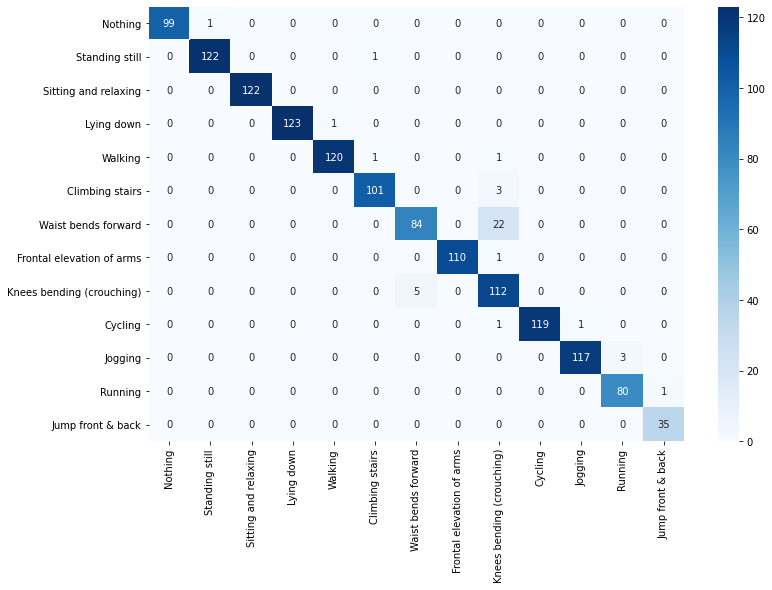

In [ ]:
plt.figure(figsize=(12,8))
conf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(conf_matrix, xticklabels= label_map.values(), yticklabels= label_map.values(), annot=True, fmt="d", cmap="Blues")
plt.show()